In [9]:
# TODO:
# -Compare against random vectors with matched norm
# - Compare against held-out RLHF deltas

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from diff_sae import DiffSAE
import config
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
checkpoint = torch.load(config.diffsae_checkpoint_path, map_location=device)
checkpoint_config = checkpoint['config']
loaded_diffsae = DiffSAE(
    input_dim=checkpoint_config['input_dim'],
    dict_size=checkpoint_config['dict_size'],
    k=checkpoint_config['k'],
    auxk=checkpoint_config['auxk']
)
loaded_diffsae.load_state_dict(checkpoint['model_state_dict'])
loaded_diffsae = loaded_diffsae.to(device).eval()

In [3]:
steering_vectors = torch.load(config.steering_vectors_filepath)
steering_vectors.keys()

dict_keys(['refusal', 'roleplay', 'uncertainty', 'helpfulness', 'format'])

In [4]:
def decompose_steering_vectors_with_diffsae(steering_vectors, diff_sae, top_k=20):
    decompositions = {}

    for category, steering_vec in steering_vectors.items():
        steering_vec = steering_vec.to(device)
        with torch.no_grad():
            latent_activations = diff_sae.encode(steering_vec.unsqueeze(0))
            latent_activations = torch.relu(latent_activations)
            reconstructed = diff_sae.decode(latent_activations)

        latent_values = latent_activations[0].cpu()
        top_k_values, top_k_indices = torch.topk(latent_values, k=top_k)
        reconstruction_error = F.mse_loss(reconstructed[0], steering_vec).item()
        projection_cosine = F.cosine_similarity(reconstructed[0].unsqueeze(0), steering_vec.unsqueeze(0)).item()

        decompositions[category] = {
            'top_k_indices': top_k_indices.numpy(),
            'top_k_values': top_k_values.numpy(),
            'reconstruction_error': reconstruction_error,
            'projection_cosine': projection_cosine,
            'sparsity': (latent_values > 1e-5).sum().item(),
            'original_norm': steering_vec.norm().item(),
            'reconstructed_norm': reconstructed[0].norm().item(),
        }

        print(f"Top-{top_k} features: {top_k_indices.numpy()[:10]}")
        print(f"Sparsity: {decompositions[category]['sparsity']}")
        print(f"MSE/Reconstrcution error: {reconstruction_error:.6f}")
        print(f"Cosine similarity: {projection_cosine:.4f}")

    return decompositions

In [5]:
decompositions = decompose_steering_vectors_with_diffsae(steering_vectors,loaded_diffsae, top_k=20)

Top-20 features: [15074 13139  5634  6625  1553  9998 11019 11112  4921 12796]
Sparsity: 6428
MSE/Reconstrcution error: 0.017074
Cosine similarity: 0.4875
Top-20 features: [15074 13139  5634  1553 17324  6625 11112  9998 11019  6802]
Sparsity: 7273
MSE/Reconstrcution error: 0.024125
Cosine similarity: 0.4955
Top-20 features: [11856 17960  7102 10378  4298  7061  5812  9542 13918  7353]
Sparsity: 7915
MSE/Reconstrcution error: 0.030084
Cosine similarity: 0.2784
Top-20 features: [17851 10515 15105  5335 14016  4995  6865 14835   179  2033]
Sparsity: 10780
MSE/Reconstrcution error: 0.086357
Cosine similarity: -0.0621
Top-20 features: [17960 11856 10378  5470  4298 11423  9542  7353  3635   676]
Sparsity: 7898
MSE/Reconstrcution error: 0.029335
Cosine similarity: 0.2777


In [6]:
def analyze_feature_overlap(decompositions):
    all_features = {}
    for category, decomp in decompositions.items():
        all_features[category] = set(decomp['top_k_indices'].tolist())

    # pairwise Jaccard similarity
    categories = list(all_features.keys())
    n_categories = len(categories)

    jaccard_matrix = np.zeros((n_categories, n_categories))
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            set1 = all_features[cat1]
            set2 = all_features[cat2]
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard_matrix[i, j] = intersection / union if union > 0 else 0

    all_feature_list = []
    for features in all_features.values():
        all_feature_list.extend(features)

    feature_counts = Counter(all_feature_list)
    shared_features = {k: v for k, v in feature_counts.items() if v >= 2}
    shared_features = dict(sorted(shared_features.items(), key=lambda x: -x[1]))

    print(f"Features appearing in multiple categories:")
    for feature_idx, count in list(shared_features.items())[:20]:
        categories_with_feature = [
            cat for cat, features in all_features.items()
            if feature_idx in features
        ]
        print(f"Feature {feature_idx:5d}: appears in {count} categories {categories_with_feature}")

    return jaccard_matrix, shared_features

In [7]:
jaccard_matrix, shared_features = analyze_feature_overlap(decompositions)

Features appearing in multiple categories:
Feature 17960: appears in 3 categories ['refusal', 'uncertainty', 'format']
Feature  7353: appears in 3 categories ['refusal', 'uncertainty', 'format']
Feature  5634: appears in 2 categories ['refusal', 'roleplay']
Feature 11019: appears in 2 categories ['refusal', 'roleplay']
Feature  9998: appears in 2 categories ['refusal', 'roleplay']
Feature  1553: appears in 2 categories ['refusal', 'roleplay']
Feature  6802: appears in 2 categories ['refusal', 'roleplay']
Feature 12368: appears in 2 categories ['refusal', 'roleplay']
Feature 13139: appears in 2 categories ['refusal', 'roleplay']
Feature  6625: appears in 2 categories ['refusal', 'roleplay']
Feature 15074: appears in 2 categories ['refusal', 'roleplay']
Feature 11112: appears in 2 categories ['refusal', 'roleplay']
Feature  9453: appears in 2 categories ['refusal', 'roleplay']
Feature 12796: appears in 2 categories ['refusal', 'roleplay']
Feature 10378: appears in 2 categories ['uncertai

In [18]:
def analyze_feature_composition(decompositions):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (category, decomp) in enumerate(decompositions.items()):
        if idx >= 6:
            break
        ax = axes[idx]
        top_k_values = decomp['top_k_values']
        top_k_indices = decomp['top_k_indices']

        ax.bar(range(len(top_k_values)), top_k_values, color='steelblue', alpha=0.7)
        ax.set_xlabel('Feature Rank', fontsize=10)
        ax.set_ylabel('Activation Strength', fontsize=10)
        ax.set_title(f'{category.capitalize()}\n(Sparsity: {decomp["sparsity"]}, Cos: {decomp["cosine_similarity"]:.3f})',
                     fontsize=11)
        ax.grid(axis='y', alpha=0.3)

        for i in range(min(5, len(top_k_values))):
            ax.text(i, top_k_values[i] + 0.01, f'{top_k_indices[i]}',
                   ha='center', va='bottom', fontsize=8)

    for idx in range(len(decompositions), 6):
        axes[idx].axis('off')

    plt.suptitle('Diff-SAE Feature Composition of Steering Vectors', fontsize=16, y=1.02)
    plt.tight_layout()

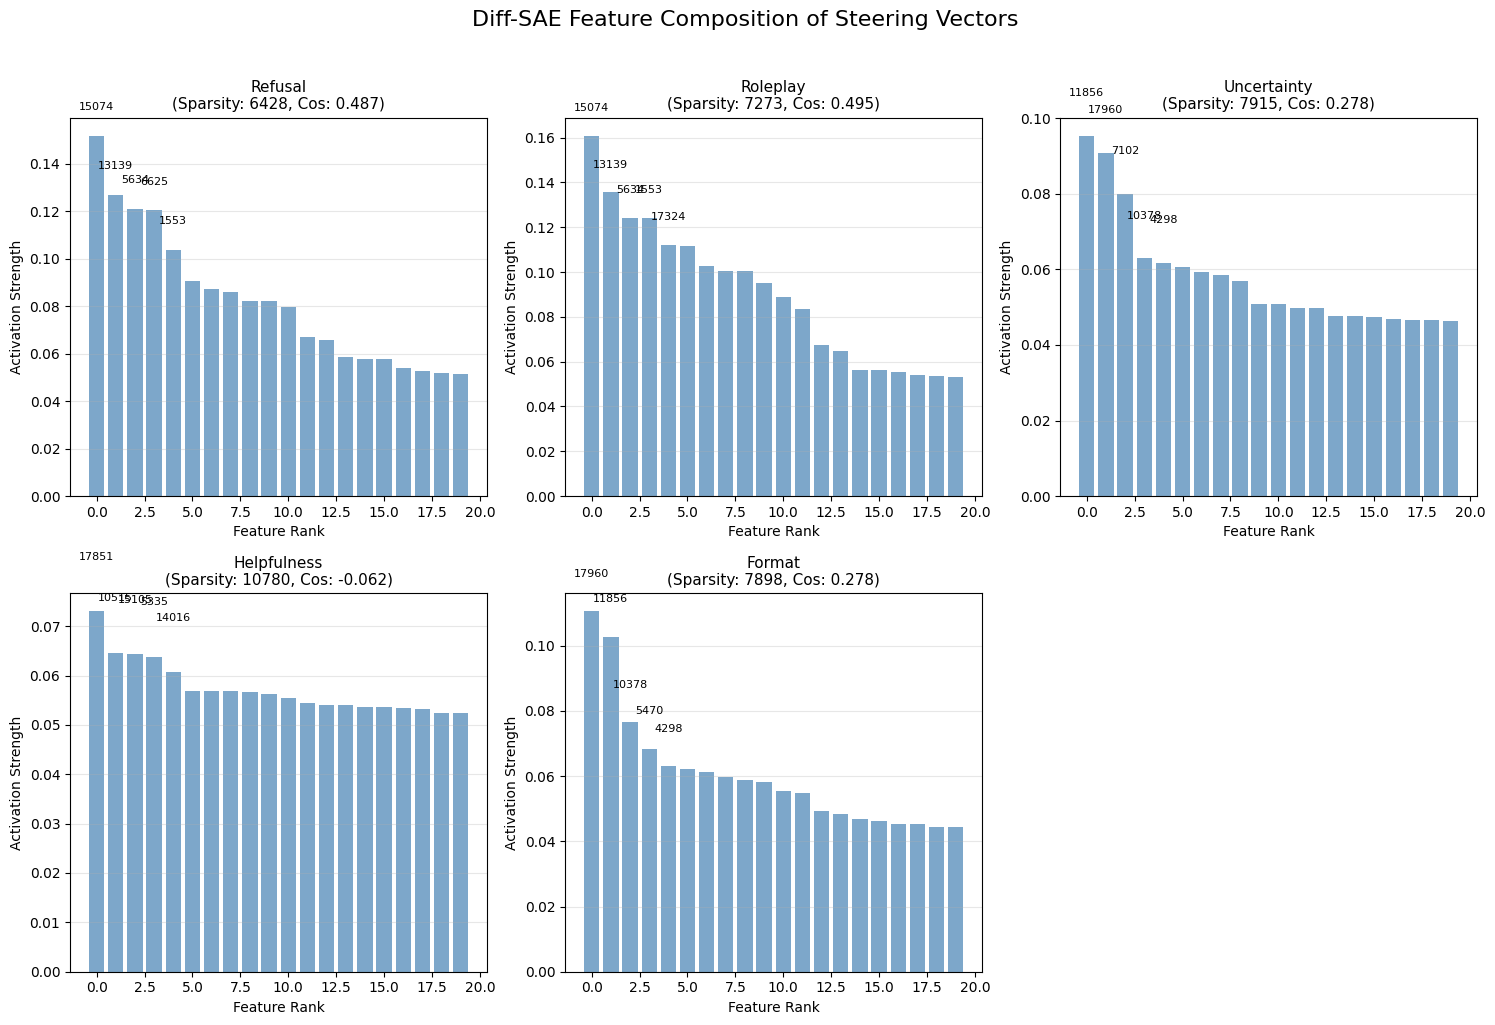

In [19]:
analyze_feature_composition(decompositions)

In [8]:
print("SUMMARY")
print()
print("Statistics")
for category, decomp in decompositions.items():
    print(f"{category.capitalize():15} | "
            f"Projection cosine: {decomp['projection_cosine']:.4f} | "
            f"MSE: {decomp['reconstruction_error']:.6f} | "
            f"Sparsity: {decomp['sparsity']:4d}/{checkpoint_config['dict_size']}")
print()
print("The results")

avg_cosine = np.mean([d['projection_cosine'] for d in decompositions.values()])
avg_error = np.mean([d['reconstruction_error'] for d in decompositions.values()])

print(f"Average projection cosine: {avg_cosine:.4f}")
print(f"Average Reconstruction MSE: {avg_error:.6f}")
print()
print("Interpretation:")
if avg_cosine > 0.8:
    print("High cosine similarity reflects linear alignment with the diff SAE subspace.")
elif avg_cosine > 0.5:
    print("The cosine similarity reflects a low linear alignment with the diff SAE subspace.")
else:
    print("The cosine similarity is too low to reflect a linear alignment with the diff SAE subspace.")

SUMMARY

Statistics
Refusal         | Projection cosine: 0.4875 | MSE: 0.017074 | Sparsity: 6428/18432
Roleplay        | Projection cosine: 0.4955 | MSE: 0.024125 | Sparsity: 7273/18432
Uncertainty     | Projection cosine: 0.2784 | MSE: 0.030084 | Sparsity: 7915/18432
Helpfulness     | Projection cosine: -0.0621 | MSE: 0.086357 | Sparsity: 10780/18432
Format          | Projection cosine: 0.2777 | MSE: 0.029335 | Sparsity: 7898/18432

The results
Average projection cosine: 0.2954
Average Reconstruction MSE: 0.037395

Interpretation:
The cosine similarity is too low to reflect a linear alignment with the diff SAE subspace.
